In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
from tqdm import trange
from flygym.mujoco import Parameters
from gymnasium.utils.env_checker import check_env
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case yeast). If it's (0, x) then it's in the 2nd dimension (in this case
# sucrose)
peak_intensity = np.array([[1, 0], [0, 1], [2, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
# marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
# marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1, 2, 20]

logging.basicConfig(level=logging.INFO)

In [2]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
)

(-0.5, 799.5, 607.5, -0.5)

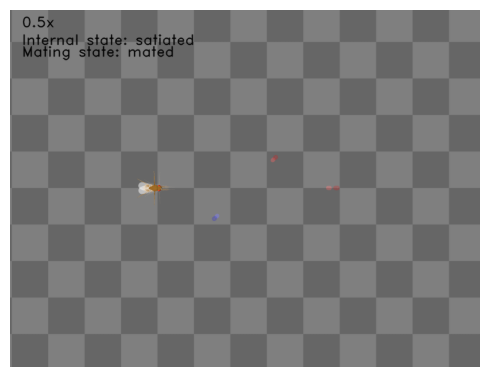

In [3]:
# Add the NeuroMechFLy

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
    food_loss_rate=0.00003,
    food_stocked_init=1.0,
    mating_state="mated",
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")

In [4]:
def generate_random_walk(num_steps):
    turnings = [np.array([1, 1])]
    count_step_turn = 0
    total_step_turn = 100
    turn = False

    for i in range(num_steps - 1):
        if count_step_turn <= total_step_turn:
            sigma_l = turnings[-1][0]
            sigma_r = turnings[-1][1]

        elif turn:
            count_step_turn = 0
            total_step_turn = np.random.gamma(120, 50)
            turn = False
            sigma_l = 1.2
            sigma_r = 1.2

        else:
            count_step_turn = 0

            while True:
                sigma_l = np.random.choice(
                    [
                        np.random.normal(1, 0.3),
                        np.random.normal(1.25, 0.2),
                        np.random.normal(0.15, 0.2),
                    ],
                    p=[0.5, 0.25, 0.25],
                )
                if sigma_l >= 0.0 and sigma_l <= 1.5:  # change before >= 0.1
                    break

            if sigma_l > 1.2:
                proba_r = np.array([0.1, 0.1, 0.8])
            elif sigma_l > 0.2 and sigma_l < 0.4:
                proba_r = np.array([0.1, 0.8, 0.1])
            elif sigma_l <= 0.2:
                proba_r = np.array([0.2, 0.8, 0.0])
            else:
                proba_r = np.array([0.6, 0.2, 0.2])

            while True:
                sigma_r = np.random.choice(
                    [
                        np.random.normal(1, 0.3),
                        np.random.normal(1.25, 0.2),
                        np.random.normal(0.15, 0.2),
                    ],
                    p=proba_r,
                )
                if sigma_r >= 0.05 and sigma_l <= 1.7:
                    break

            if np.abs(sigma_l - sigma_r) > 0.65:
                total_step_turn = np.random.gamma(140, 65)
                turn = True
            else:
                total_step_turn = np.random.gamma(50, 30)

        count_step_turn += 1

        turnings.append(np.array([sigma_l, sigma_r]))

    return turnings

In [16]:
run_time = 8
turns = generate_random_walk(int(run_time / sim.sim_params.timestep))

In [17]:
obs_hist = []
odor_history = []
obs, _ = sim.reset()

In [18]:
for i in trange(int(run_time / sim.sim_params.timestep)):
    action = turns[i]
    obs, _, _, _, _ = sim.step(action)
    rendered_img = sim.render()
    obs_hist.append(obs)

100%|██████████| 80000/80000 [03:38<00:00, 366.88it/s]


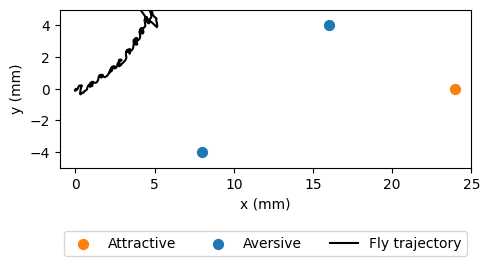

In [19]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))

In [20]:
sim.save_video("/home/nmf-learning/flygym-scratch/outputs/random_walk/second_try.mp4")